In [11]:
import cv2
import pytesseract
from imutils.perspective import four_point_transform
from rembg import remove
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd

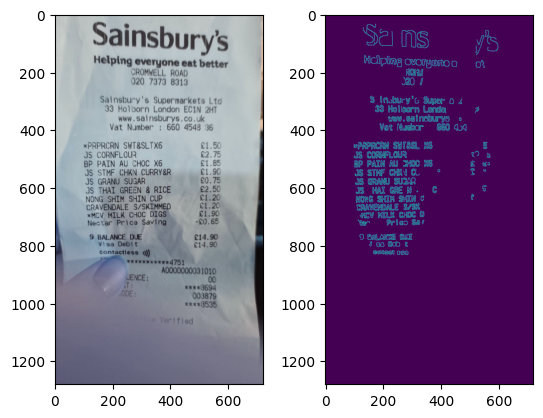

In [12]:
img_path = 'Downloads/cropped.jpg'
orig = cv2.imread(img_path)
image = orig.copy()
removed = remove(image)
gray = cv2.cvtColor(removed, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
edged = cv2.Canny(blurred, 75, 200)

plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(edged)
plt.show()

In [8]:
def smooth_contour_points(contour, delta=10):
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
    c = approx.squeeze(1).copy()
    for i in range(len(c)):
        if np.prod(c[i] < 0):
            continue
        diff = abs(c[i] - c)
        inds = np.where(np.prod(diff<delta, axis=1) == 1)[0]
        for ind in inds:
            if ind != i:
                c[ind] = -1
    c = c[c > 0].reshape(-1,2)
    return c

def get_four_points(coords, delta=50):
    
    def filter_corners(coords, points, delta):
        (left,right,top,bottom) = points
        corners = []
        for (x,y) in coords:
            if (x <= left+delta or x >= right-delta) and (y <= top+delta or y >= bottom-delta):
                corners.append([x,y])
        return np.array(corners)
    
    xsort = np.sort(coords[:,0])
    left,right = xsort[0], xsort[-1]
    ysort = np.sort(coords[:,1])
    top,bottom = ysort[0], ysort[-1]
    
    corners = filter_corners(coords, (left,right,top,bottom), delta)
    while len(corners) != 4:
        delta += 10
        corners = filter_corners(coords, (left,right,top,bottom), delta)
    
    return np.array(corners)

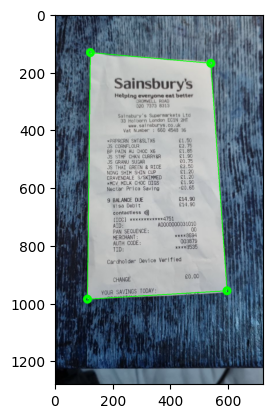

In [9]:
contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda c: cv2.contourArea(smooth_contour_points(c)), reverse=True)
c = np.r_[contours[0],contours[1]]
smoothed_coords = smooth_contour_points(c)
coords = get_four_points(smoothed_coords)
output = image.copy()
for x,y in coords:
    cv2.circle(output, (x,y), 10, (0,255,0), 10)
cv2.drawContours(output, [coords.reshape(-1,1,2)], -1, (0, 255, 0), 2)
plt.imshow(output)
plt.show()

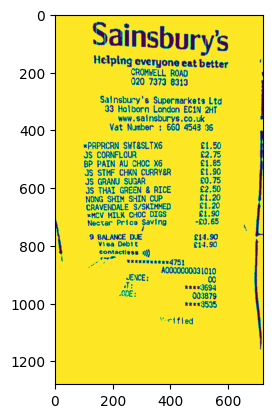

In [16]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
receipt = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 15)
plt.imshow(receipt)
plt.show()

In [17]:
text = pytesseract.image_to_string(receipt, config='--psm 4')
pricePattern = r'([0-9]+[\.,][0-9]+)'
items = { "Item":[], "Price":[] }
for row in text.split("\n"):
    m = re.search(pricePattern, row)
    if m:
        items["Item"].append(" ".join(row.split(" ")[:-1]))
        items["Price"].append(m.group().replace(",","."))
pd.DataFrame(items)

,Item,Price
0,xPRPRCRN SWT8SLTXE,1.50
1,JS CORNFLOUR,2.75
2,8P PAIN AU CHOC X6,1.85
3,JS STHMF CHKN CURRY&R,1.90
4,JS GRANU SUGAR,0.75
5,JS THAT GREEN & RICE,2.50
6,NONG SHIM SHIN CUP,1.20
7,CRAVENDALE 5/SKIMMED,1.20
8,*MCV MILK CHOC DIGS,1.90
9,Nectar Prica lSaVing -£0.65,0.65
